In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import timedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
stations = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_date = (session.query(measurement.date).order_by(measurement.date.desc()).first())
last_date = last_date[0]

#last_date
last_date = dt.datetime.strptime(last_date,'%Y-%m-%d')

# Calculate the date 1 year ago from the last data point in the database
year = timedelta(days=365)
one_year_ago = last_date - year

# Perform a query to retrieve the data and precipitation scores
scores = session.query(measurement.date, measurement.prcp).filter(measurement.date > one_year_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
last_year_scores_df = pd.DataFrame(scores)
    
# Sort the dataframe by date
last_year_scores_df = last_year_scores_df.sort_values('date')

# Set 'date' column as index. Format 'date' column as date. 
last_year_scores_df['date'] = pd.to_datetime(last_year_scores_df['date'],format='%Y-%m-%d')
last_year_scores_df.reset_index(drop=True, inplace=True)
last_year_scores_df = last_year_scores_df.set_index('date')

In [11]:
# Create week bins
last_year_scores_df = last_year_scores_df.resample('W').sum()

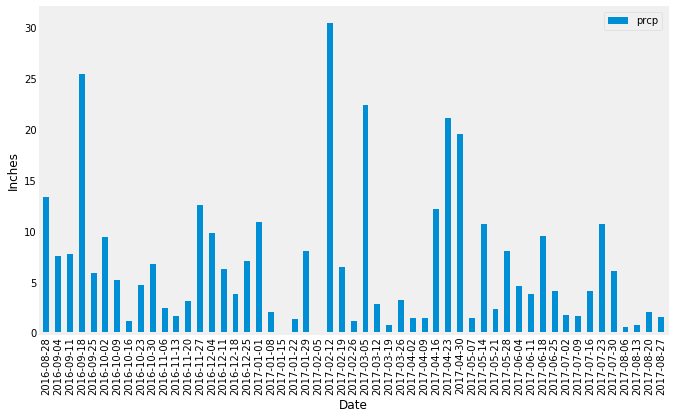

In [12]:
# create bar chart and update the date format for the weeks
ax = last_year_scores_df.plot(kind='bar',figsize=(10, 6))
ax.set_xticklabels(last_year_scores_df.index.strftime('%Y-%m-%d'), rotation=90)
ax.grid(False)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.show()

In [13]:
#peeking inside stations
first_row_station = session.query(stations).first()
first_row_station.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11c5f6d10>,
 'name': 'WAIKIKI 717.2, HI US',
 'longitude': -157.8168,
 'id': 1,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [14]:
#peeking inside measurement
first_row_measurement = session.query(measurement).first()
first_row_measurement.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11c63e050>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1,
 'tobs': 65.0}

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
all_scores = session.query(measurement.date, measurement.prcp).all()
all_scores_df = pd.DataFrame(all_scores)
all_scores_df.describe()

,prcp
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [16]:
# Design a query to show how many stations are available in this dataset?
no_of_stations = session.query(stations).count()
print ('There is %s stations in the dataset.'% no_of_stations ) 

There is 9 stations in the dataset.


In [38]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
the_most_active = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by(func.count(measurement.station).desc()).all()
the_most_active[0]

('USC00519281', 2772)

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
the_station = the_most_active[0]
station_id = the_station[0]

lowest = session.query(measurement.tobs, func.min(measurement.tobs)).filter(measurement.station == station_id).all()
highest = session.query(measurement.tobs, func.max(measurement.tobs)).filter(measurement.station == station_id).all()
average = session.query(measurement.tobs, func.avg(measurement.tobs)).filter(measurement.station == station_id).all()

print ("The lowest temperature recorder in station %s was %s °F." % (station_id, lowest[0][0]))
print ("The highest temperature recorder in station %s was %s °F." % (station_id, highest[0][0]))    
print ("The average temperature recorder in station %s was %s °F." % (station_id, average[0][0]))

The lowest temperature recorder in station USC00519281 was 54.0 °F.
The highest temperature recorder in station USC00519281 was 85.0 °F.
The average temperature recorder in station USC00519281 was 70.0 °F.


In [20]:
#tobs_data = session.query(measurement.date, measurement.tobs).filter(measurement.station == station_id).order_by(measurement.date).all()

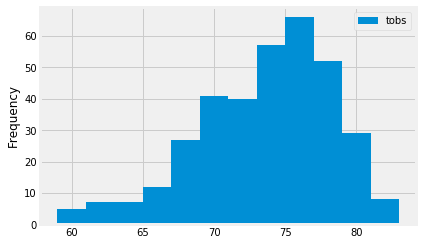

In [22]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures = session.query(measurement.date,measurement.tobs).filter(measurement.station == station_id).filter(measurement.date > one_year_ago).all()
temperatures = pd.DataFrame(temperatures)
temperatures.plot(kind='hist', bins=12)

## Bonus Challenge Assignment

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
        filter(measurement.date >= start_date).filter(measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [22]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
print(calc_temps('2017-07-18', '2017-07-25'))

[(72.0, 78.50980392156863, 83.0)]


In [25]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
